# Automatic Number Plate Recognition System

# 1. Dependencies

**Note**: Newer Python versions require users to install dependencies in a virtual environment. Learn how to create a virtual environment [here](https://docs.python.org/3/library/venv.html), or if using Visual Studio Code, [here](https://code.visualstudio.com/docs/python/environments).

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!pip install ultralytics scikit-learn tqdm

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import xml.etree.ElementTree as xet
import cv2
import re
import os
from glob import glob

from sklearn.model_selection import train_test_split
import shutil

from tqdm import tqdm

Make sure CUDA is available. CUDA is a program created by Nvidia that gives PyTorch direct access to the GPU, making processing way more efficient. CUDA cores (or devices) are computer cores that are specialised for parallel computing. If there aren't any CUDA cores available, it's probably because you're running the notebook on a CPU, not a GPU. Google Colab offers


In [4]:
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


# 2. Preprocessing

## 2.1 Define preprocessing

In [5]:
def preprocess_image(image):
    if image is None:
        print("Error: Image not found.")
        return
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply the Sobel operator in the X direction
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    # Apply the Sobel operator in the Y direction
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate the magnitude of the gradients
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    # Normalize to 0 to 255
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))

    return magnitude

In [6]:
def process_dataset(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get list of all image files
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png'))]

    # Process each image
    for filename in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error reading image: {filename}")
            continue

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Save the processed image
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, processed_image)

## 2.2 Preprocess images in dataset

In [7]:
input_directory = "dataset/images"
output_directory = "dataset/preprocessed_images"

process_dataset(input_directory, output_directory)

Processing images: 100%|████████████████████████████████████████████████████████████| 433/433 [00:03<00:00, 115.92it/s]


# 3. Data

## 3.1 Find data

In [8]:
dataset_path = "dataset"

In [9]:
def extract_number_from_str(filename):
    """Function to find a given image or label number to adjoin images and labels together."""
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [10]:
# Store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

In [11]:
# get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
assert xml_files, "Couldn't find dataset. Make sure to upload the dataset to Colab."

In [12]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=extract_number_from_str):

    info = xet.parse(filename)
    root = info.getroot()

    # Extract bounding box coordinates
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'preprocessed_images', img_name)

    # add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    alldata = pd.DataFrame(labels_dict)

alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,dataset\preprocessed_images\Cars0.png,226,419,125,173,500,268
1,dataset\preprocessed_images\Cars1.png,134,262,128,160,400,248
2,dataset\preprocessed_images\Cars2.png,229,270,176,193,400,400
3,dataset\preprocessed_images\Cars3.png,142,261,128,157,400,225
4,dataset\preprocessed_images\Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,dataset\preprocessed_images\Cars428.png,142,258,128,157,400,225
429,dataset\preprocessed_images\Cars429.png,86,208,166,195,301,400
430,dataset\preprocessed_images\Cars430.png,38,116,159,197,400,225
431,dataset\preprocessed_images\Cars431.png,55,343,82,147,400,192


## 3.2 Split data

In [13]:
# Split dataset for training, testing and validation
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
Number of images in each set
Training:   {len(train)} images
Validation:  {len(val)} images
Testing:     {len(test)} images
''')


Number of images in each set
Training:   345 images
Validation:  44 images
Testing:     44 images



## 3.3 Convert data to YOLO format

In [14]:
def make_split_folder_in_yolo_format(split_name, split_df):
    # folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plates', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plates', split_name, 'images')

    if not os.path.exists(labels_path):
        os.makedirs(labels_path)
        os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")


        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [15]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets\cars_license_plates\train\images' and 'datasets\cars_license_plates\train\labels'
Created 'datasets\cars_license_plates\val\images' and 'datasets\cars_license_plates\val\labels'
Created 'datasets\cars_license_plates\test\images' and 'datasets\cars_license_plates\test\labels'


# Object detection and bounding box

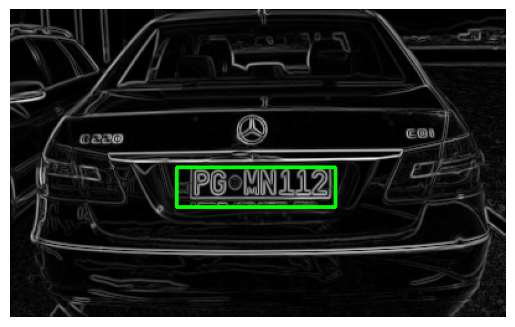

In [16]:
image_dir = 'datasets/cars_license_plates/train/images'
label_dir = 'datasets/cars_license_plates/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [23]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# Using YOLOv8 nano model

In [24]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [25]:
os.environ['WANDB_MODE'] = 'offline'

In [26]:
def train_with_preprocessing(model, train_data):
    def preprocessed_dataset(data):
        for batch in data:
            yield [preprocess_image(img) for img in batch]

    results = model.train(data=preprocessed_dataset(train_data), epochs=100, imgsz=640)

In [22]:
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True
)

New https://pypi.org/project/ultralytics/8.3.18 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.9  Python-3.10.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning E:\Documents\Desktop\project\3.sobel_convert\datasets\cars_license_plates\train\labels... 345 images, 0

train: New cache created: E:\Documents\Desktop\project\3.sobel_convert\datasets\cars_license_plates\train\labels.cache
WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:00<00:00, 5516.55it/s]
val: Scanning E:\Documents\Desktop\project\3.sobel_convert\datasets\cars_license_plates\val\labels... 44 images, 0 back

val: New cache created: E:\Documents\Desktop\project\3.sobel_convert\datasets\cars_license_plates\val\labels.cache
WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 3999.94it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.671G      1.909       3.57      1.379         16        320: 100%|██████████| 22/22 [00:01<00:00, 14.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44    0.00323      0.773      0.145     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.642G      1.647      2.418       1.13         18        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44    0.00437      0.886      0.211     0.0666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.642G      1.648      1.629      1.188         13        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44    0.00403      0.818      0.016    0.00624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.644G      1.625      1.499      1.199         19        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44    0.00378      0.886     0.0886     0.0359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.642G      1.619      1.421      1.199         11        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.782      0.205      0.243     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.642G      1.574      1.425      1.211         14        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.728      0.432      0.637      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.642G      1.498      1.259       1.16         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.601      0.682      0.624      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.644G      1.527      1.231      1.165         15        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.604      0.455      0.499      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.642G      1.481      1.167      1.155         14        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.782      0.569      0.695      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.644G      1.529      1.171      1.174         17        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.82      0.841      0.814      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.644G      1.479      1.126      1.161         17        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.781       0.81      0.882      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.642G      1.476      1.088      1.143         15        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.77      0.614      0.655      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.642G      1.444       1.07      1.132         14        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.593      0.659      0.628      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.642G      1.416      1.018      1.114         22        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.66      0.707      0.749      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.642G      1.411     0.9659      1.111         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.947      0.886      0.888      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.642G      1.412     0.9578      1.103         18        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.891      0.746      0.834      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.642G      1.361      0.936      1.122         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.808      0.727      0.822      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.642G      1.381     0.9152      1.105         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.849      0.764      0.842      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.642G      1.352     0.8966      1.096         20        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.828      0.864      0.891      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.642G      1.363     0.8867      1.091         21        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.916      0.795      0.888      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.642G      1.366     0.8726      1.089         22        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.82      0.864      0.897      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.642G      1.339      0.872      1.096         11        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.858      0.826      0.903      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.642G      1.268     0.8333      1.074         20        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.836      0.841      0.895      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.642G      1.258      0.832      1.057         14        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.927      0.872      0.924      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.642G      1.274     0.8143      1.045         19        320: 100%|██████████| 22/22 [00:00<00:00, 26.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.915      0.818      0.923      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.642G      1.278     0.8061      1.068         22        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.806      0.864      0.904      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.642G      1.205     0.7934      1.031         17        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.827      0.864      0.871      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.642G       1.22     0.7826      1.047         17        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.897      0.886      0.879      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.642G       1.23     0.7744      1.058         15        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.882      0.852      0.905      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.642G      1.243     0.8123       1.05         13        320: 100%|██████████| 22/22 [00:00<00:00, 26.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.848      0.885      0.902      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.642G      1.217     0.8014      1.041         12        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.88      0.886      0.895      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.642G      1.232     0.7872      1.046         18        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.927      0.909      0.942      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.642G      1.215     0.7365      1.043         17        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.893      0.864      0.904      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.642G      1.237     0.7469      1.043         15        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.873      0.818      0.838       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.642G       1.11     0.7067      1.016         15        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.818      0.819      0.863      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.644G      1.124     0.7034      1.006         17        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.983      0.864      0.918      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.642G       1.14     0.7195      1.013         20        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.805      0.818      0.829      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.642G      1.115     0.6973      1.013         16        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.81      0.886      0.901      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.642G      1.172     0.7075      1.001         21        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.836      0.886      0.882      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.644G      1.254      0.727      1.041         20        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.866      0.864      0.895      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.642G      1.172     0.6993       1.01         24        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.883      0.864      0.911      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.642G       1.15     0.6693      1.009         15        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.895      0.841      0.916        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.642G      1.053     0.6507     0.9889         13        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.902      0.864      0.919      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.642G      1.113     0.6644      1.025         14        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.893      0.841      0.901      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.642G       1.08     0.6457      1.009         12        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.906       0.88      0.912      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.642G      1.051     0.6353     0.9865         16        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.885      0.909      0.933      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.642G      1.072     0.6448     0.9971         18        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.888      0.909       0.92      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.642G      1.079     0.6606      1.025         17        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44        0.9      0.818      0.924      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.642G      1.047     0.6538     0.9677         16        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.894      0.818      0.913      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.642G      1.023     0.6533     0.9763         20        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.865      0.877      0.925      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.642G      1.073     0.6414      1.013         20        320: 100%|██████████| 22/22 [00:00<00:00, 26.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.928      0.864      0.936      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.642G      1.053     0.6227     0.9907         17        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.908      0.886      0.934      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.642G      1.022     0.6234     0.9842         18        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.816      0.907      0.909      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.642G      1.046      0.624     0.9807         21        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.915      0.818      0.887      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.642G      1.006     0.6178     0.9741         18        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.899      0.795      0.901      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.642G      1.021     0.6272     0.9724         17        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.883      0.858      0.901      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.642G      1.028     0.6067     0.9762         15        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.92      0.864      0.923       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.642G      1.031     0.6312     0.9742         15        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.932      0.886      0.941      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.642G     0.9966     0.6181     0.9789         17        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.953      0.864      0.917      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.642G     0.9997     0.5919     0.9628         19        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.892      0.955      0.942      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.642G     0.9855     0.5905     0.9605         21        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.928      0.876      0.927      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.644G     0.9686     0.5875      0.958         19        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.906      0.873      0.925       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.642G      0.949     0.5518     0.9394         14        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.898      0.864      0.934      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.642G     0.9806     0.5778     0.9657         13        320: 100%|██████████| 22/22 [00:01<00:00, 19.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.903      0.843      0.924      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.642G     0.9417     0.5645     0.9537         17        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.897      0.864      0.903      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.644G     0.9334     0.5777      0.955         21        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.95      0.858      0.915      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.642G     0.8854     0.5596      0.943         20        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.925      0.841      0.916      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.642G     0.9137      0.546     0.9239         20        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.897      0.864      0.921      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.642G     0.9008     0.5431     0.9509         18        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.867      0.885      0.917      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.642G     0.9229     0.5473     0.9453         17        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.885      0.909      0.915      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.642G     0.9167     0.5405     0.9501         13        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.885      0.909      0.918      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.644G     0.8825     0.5381     0.9364         12        320: 100%|██████████| 22/22 [00:01<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.888      0.904      0.926      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.642G     0.9373     0.5531     0.9534         18        320: 100%|██████████| 22/22 [00:01<00:00, 18.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.951      0.877      0.922      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.642G     0.9016     0.5479     0.9411         12        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.882      0.886      0.921      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.642G     0.9068     0.5525     0.9599         12        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.891      0.927      0.927      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.642G     0.8995     0.5386     0.9477         18        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.881      0.909      0.913      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.642G     0.8484     0.5141     0.9204         25        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.893      0.952      0.911      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.642G     0.8768     0.5226     0.9318         15        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.906      0.886      0.914      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.642G     0.8951     0.5257     0.9321         15        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.904      0.886      0.925      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.642G     0.8295     0.5231     0.9269         12        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.891      0.909      0.935      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.642G     0.8131     0.5104     0.9227         17        320: 100%|██████████| 22/22 [00:00<00:00, 22.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44       0.89      0.932      0.926      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.642G     0.8773     0.5234     0.9243         24        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.904      0.909      0.914      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.642G     0.8563     0.5156     0.9225         10        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.893      0.886      0.924      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.642G      0.843     0.4954     0.9277         17        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.902      0.864      0.926      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.642G     0.7919     0.4894     0.9189         21        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.882      0.864       0.91      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.642G     0.8201     0.4816     0.9141         12        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.866      0.885      0.908      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.642G     0.8379     0.5112     0.9202         12        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.863      0.857      0.905      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.642G     0.8059     0.4987     0.9224         17        320: 100%|██████████| 22/22 [00:01<00:00, 21.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.879      0.864      0.917      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.642G     0.7858     0.4913     0.9149         20        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.883      0.864      0.923       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.642G     0.7917     0.4777     0.9077         22        320: 100%|██████████| 22/22 [00:01<00:00, 20.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.877      0.864      0.927      0.493


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.642G      1.031     0.6342      0.975          9        320: 100%|██████████| 22/22 [00:01<00:00, 17.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.854      0.928      0.933      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      0.64G      1.022     0.5602     0.9912          9        320: 100%|██████████| 22/22 [00:00<00:00, 24.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.869      0.907      0.932       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.642G      1.033     0.5672      1.001          9        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.886      0.884      0.933      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.642G     0.9719     0.5265     0.9806          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.876      0.909      0.934      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.642G      1.005     0.5445     0.9915          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.886      0.887      0.933      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.642G      0.955     0.5292     0.9446          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.907      0.882      0.924      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      0.64G     0.9786     0.5125      0.972          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44        0.9      0.886      0.922      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.642G     0.9574     0.5076      0.958          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.898      0.886      0.921      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.64G      0.945     0.5109     0.9755          9        320: 100%|██████████| 22/22 [00:00<00:00, 23.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.899      0.886      0.922      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.642G     0.9548     0.5147      0.966          9        320: 100%|██████████| 22/22 [00:00<00:00, 25.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         44         44      0.901      0.886      0.923      0.534



100 epochs completed in 0.042 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.6MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.6MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.9  Python-3.10.11 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         44         44      0.884      0.909      0.917      0.545
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021492E5E770>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

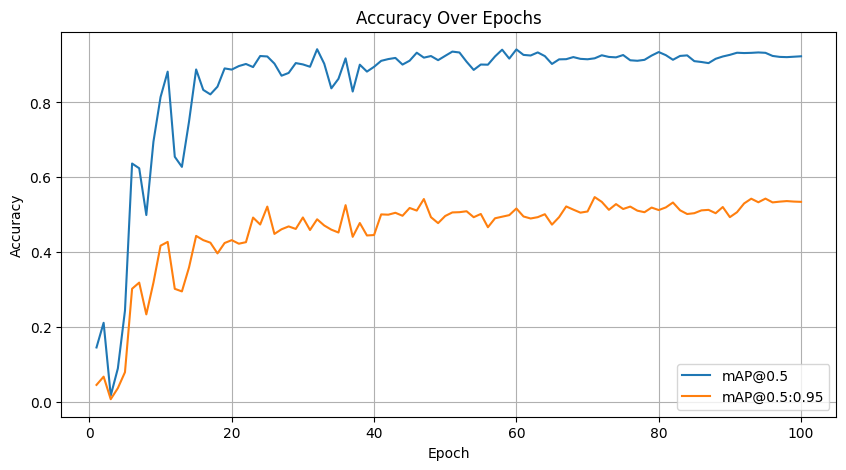

In [27]:
# Find recent training log dir
log_dir = max(glob('runs/detect/train*'), key=extract_number_from_str)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# save model
model.save('anpr-v1.pt')

# Test and predictions

In [29]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 E:\Documents\Desktop\project\3.sobel_convert\dataset\preprocessed_images\Cars425.png: 320x640 1 bus, 37.7ms
Speed: 1.0ms preprocess, 37.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


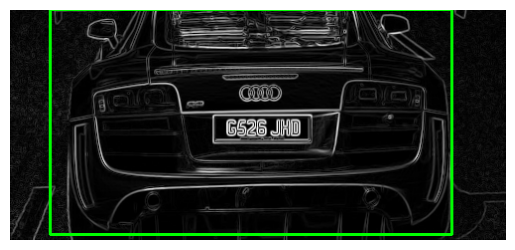

In [30]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 E:\Documents\Desktop\project\3.sobel_convert\dataset\preprocessed_images\Cars181.png: 640x384 1 car, 48.6ms
Speed: 0.8ms preprocess, 48.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


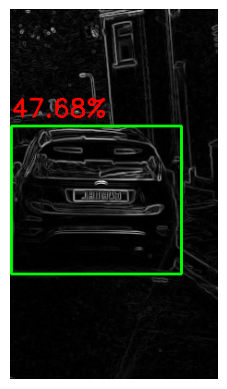

In [31]:
predict_and_plot(test.iloc[2].img_path)